# A tutorial on probabilistic models of single-cell gene expression and Bayesian inference within STAN

*Nick Phillips, Naef lab, EPFL, 28/06/21*

## Introduction

This is a tutorial to accompany our paper that was recently published in Molecular Systems Biology: "The circadian oscillator analysed at the single‐transcript level" https://doi.org/10.15252/msb.202010135. 

While our particular model was customised for circadian biology, the approach and tools are general and can be adapted to a wide range of different biological problems. Within this approach, the goal is to define a generative model of single-cell gene expression and infer the parameters of the model within a Bayesian framework, which can be used to e.g. compare two different genes or cell populations.

As part of this Bayesian inference strategy we'll be forced to use a probabilistic, generative model of the single-cell data. But how do we define a model or decide which is the best? We'll see that there are multiple models that can be used for single-cell gene expression, and each model has its strengths and weaknesses. There are two main objectives of this tutorial:

* to give an overview of several probability distributions of single-cell gene expression based on simple biophysical models
* to show how these models can be implemented in STAN for Bayesian inference

The most important message is this: probabilistic programming languages such as STAN make Bayesian inference so much more accessible for practitioners, and the straightforward implementation of the analysis pipeline means that users can spend more time thinking about the biological questions and experimenting with different models. However, while the implementation of Bayesian models is now much easier, there are still an enormous number of problems/subtleties that can arise, and we will also see a few basic failure modes that are important to think about.

Contents:

1. A quick intro to Bayesian data analysis and STAN
2. A quick intro to biophysical models of single-cell gene expression
3. Model 1: the Poisson distribution
4. Model 2: the beta-Poisson distribution
5. Model 3: the negative binomial (gamma-Poisson) distribution
6. Model 4: the multivariate log-normal Poisson mixture distribution
7. Model 5: incorporating extrinsic noise explicitly
8. Technical noise
9. Model selection and validation
10. Strengths and limitations of the approach

## A quick intro to Bayesian data analysis and STAN

If you're a complete beginner to Bayesian analysis then I recommend first starting with the book "Statistical Rethinking" by Richard McElreath [1](https://xcelab.net/rm/statistical-rethinking/), which starts from the basics and is aimed at individuals from diverse (including non-quantitative) backgrounds. And here are a few videos that dive into Bayesian inference and STAN a bit more:

* Julia Galef - A visual guide to Bayesian thinking [2](https://youtu.be/BrK7X_XlGB8)
* Richard McElreath - Stastistical Rethinking course [3](https://youtu.be/4WVelCswXo4)
* Aki Vehtari - Bayesian Data Analysis course [4](https://avehtari.github.io/BDA_course_Aalto/index.html)
* Michael Betancourt - on MCMC [5](https://www.youtube.com/watch?v=UzcLe-kpMDQ). 

Here I'll attempt to summarise some of the core concepts of Bayesian data analysis, but I hope the actual mechanics will become clearer when we look at some practical examples below.

Before launching into the practical details of Bayesian inference for single-cell gene expression, it's worth noting some of the advantages and disadvantages of this approach. An essential feature of Bayesian analysis is that we're forced to describe a generative model of the data, which isn't necessarily true for all data analysis approaches (e.g. t-SNE). With a model we're able to ask hypothetical "but what if?" type questions that can predict outcomes of interventions to biological systems *before* doing the experiment. We can also use models to explicitly disentangle cell-to-cell variability caused by biological sources vs technical noise, and this recent article is a concrete example of why this can be important [6](https://doi.org/10.1038/s41587-021-00875-x). However, a natural question is: how do we know that we have a good model of our data? And how do we even define a "good" model? We'll revisit this question in section 8. 

We'll define our models and perform Bayesian inference with STAN [7](https://mc-stan.org), and here are some of the benefits:

* In STAN you define the model at a high level and you don't have to write a custom inference algorithm every time you'd like to change the model (it's a big time-saver)
* Several textbooks for Bayesian inference (Statistical Rethinking, Bayesian Data Analysis 3rd edition, Regression and Other Stories) show many examples of different models in STAN .
* There are loads of interesting online tutorials and resources (see e.g. tutorials from Aki Vehtari [8](https://avehtari.github.io) or Michael Betancourt [9](https://betanalpha.github.io/writing/) )
* There's a large user community and the reference manual is comprehensive.
* It's available for R, Python and more. 

The goal of this tutorial is not to cover the best practices/workflow for Bayesian inference (see e.g. this paper [10](https://arxiv.org/pdf/2011.01808.pdf) or this blog [11](https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html) ), as we'll mainly focus on the probabilistic models of single-cell gene expression. We'll skip some (quite important) steps in the Bayesian analysis pipeline (including MCMC diagnostics to check that the inference behaved as expected), so check out these other resources if you'd like further information on these general principles.

So what's the big picture? Starting from a simple biophysical model of gene expression, we'll derive several different probability distributions that can be used as part of the STAN inference framework to describe single-cell gene expression datasets. For each gene in our experiment we have a dataset of single-cell mRNA counts (that could come from either smFISH or single-cell RNA-seq) that we'll label $y$, and each model will have some parameters that we label $\theta$ (e.g. transcription rate, mRNA degradation rate etc., see below). We'll use STAN to infer the parameters of our model from the data. Specifically, we'll write our model in STAN, feed it with our data and then draw samples from the "posterior probability distribution" of our model. These samples will (hopefully) reveal the range of plausible values of the model parameters, given the data. We can also use these parameter samples to simulate synthetic datasets (known as the posterior predictive distribution) and check that the model simulations resemble the data (perhaps there's a particular qualitative feature of the dataset that you're interested in?). We can also change a subset of parameters to explore "what if" type questions (e.g. what would the mRNA distribution look like if we could double the transcription rate?).

For the purposes of this tutorial, the formula we need for Bayesian inference is this:

$p(\theta|y) \propto p(y|\theta)p(\theta)$

Which has three components:

* $p(\theta|y)$ - the posterior parameter distribution. This is a probability distribution that expresses our belief/uncertainty of the parameters $\theta$ given the data $y$. This is the output of STAN, and it's the thing we're interested in.
* $p(y|\theta)$ - the likelihood of the data $y$ given the model parameters $\theta$. In order to calculate this, we'll need to input a model that describes the distribution of mRNA counts ($y$) given the model parameters $\theta$. We'll discuss four possible options based on simple biophysical models below.
* $p(\theta)$ - the prior distribution. This encodes our state of belief about the parameter values before we see any data. Ideally, here we would insert some expert knowledge on the range of plausible values for each parameter (for example, there are certainly upper limits on possible transcription rates due to the physical constraints of the cell). For illustration, we'll assume that we know very little about the possible values of the parameters and use a "weakly informative prior", but in some cases this is actually not recommended.

In order for STAN to sample the posterior parameter distribution, we'll need to supply:

1. Data
2. A model 
3. A prior distribution for each parameter

We'll next go over some simple models that can be used within STAN.

## A quick intro to biophysical models of single-cell gene expression

mRNA production and degradation result from random collisions between finite numbers of interacting molecules within the cell, which creates biological noise known as intrinsic stochasticity. I particularly like this paper from Dattani & Barahona [12](https://doi.org/10.1098/rsif.2016.0833) that describes a conceptual framework for unifying many diverse models of gene expression. We'll use their framework for defining a general, stochastic model of gene expression, where mRNA molecules are produced and degraded according to the following reaction scheme:

\begin{align}
\emptyset \overset{M_t}\longrightarrow \text{mRNA} \overset{L_t}\longrightarrow \emptyset
\end{align}

and where the production rate $M_t$ and degradation rate $L_t$ can be stochastic, time-varying functions. The interesting aspect of the approach is that you can break the solution into two simpler problems. First, you solve a differential equation for a new variable $X_t$ that has the same production and degradation rates as the original problem (this will be a random differential equation if either $M_t$ or $L_t$ is stochastic)

\begin{align}
\frac{dX_t}{dt} = M_t - L_t X_t
\end{align}

Solving this equation will give the probability density function of the process $X_t$ as $p_{X_t}(x,t)$. To describe the probability distribution of the mRNA molecules, we next take this distribution and plug it into this formula that describes a Poisson mixture distribution (ignoring the ‘burn-in’ transient towards stationarity):

\begin{align}
p(n,t)=\int \frac{x^n}{n!} e^{-x}p_{X_t}(x,t) dx
\end{align}

So to reiterate: we first solve a simpler problem to calculate a mixing density $p_{X_t}(x,t)$ and then use it to define the Poisson mixture distribution. In some cases the integral can be perfomed analytically, and in other cases we can introduce "latent variables" as extra parameters within STAN to take care of the integration. Hopefully this will become clearer with a few examples.

## Model 1: the Poisson distribution

We'll start with the simplest example: let's imagine that there's a constant rate of production and degradation (transcription rate $M_t = \alpha$ and degradation rate $L_t = \gamma$), which is often referred to a "consitutive gene expression". In this case we simply recover a Poisson distribution, which only has one parameter known as the rate parameter $\lambda$ (equal to $\lambda = \alpha/\gamma$ for this model). Both the mean and variance of the Poisson distribution are given by this rate parameter, and so the larger the ratio of production to degradation, the larger the mean and variance of the mRNA distribution. Interestingly, even for this simple model we can see that there might be problems with recovering the parameters during inference. Below I've simulated this model (externally, with the Gillespie algorithm) using two different combinations of parameters (fast dynamics: $\alpha = 30$, $\gamma = 1$, slow dynamics: $\alpha = 3$, $\gamma = 0.1$). 

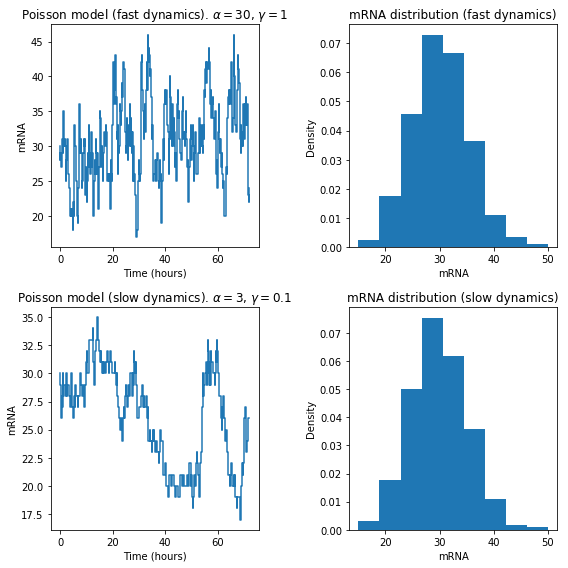

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy.stats import nbinom

t = pd.read_csv('Time.csv',header=None).values  
y_fast = pd.read_csv('Model1_fast.csv',header=None).values  
y_slow = pd.read_csv('Model1_slow.csv',header=None).values  

def plot_time_series(t,y):
    plt.plot(t,y,linestyle = 'steps') 
    plt.ylabel('mRNA')
    plt.xlabel('Time (hours)')

def plot_hist(y,bins):
    plt.hist(y,bins=bins,density=True)
    plt.xlabel('mRNA')
    plt.ylabel('Density')
      
fig = plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plot_time_series(t,y_fast[:,0])  
plt.title(r'Poisson model (fast dynamics). $\alpha = 30$, $\gamma = 1$')

plt.subplot(2,2,2)
plot_hist(y_fast[-1,:],bins=np.linspace(15,50,10))
plt.title(r'mRNA distribution (fast dynamics)')

plt.subplot(2,2,3)
plot_time_series(t,y_slow[:,0])  
plt.title(r'Poisson model (slow dynamics). $\alpha = 3$, $\gamma = 0.1$')

plt.subplot(2,2,4)
plot_hist(y_slow[-1,:],bins=np.linspace(15,50,10))
plt.title(r'mRNA distribution (slow dynamics)')

plt.tight_layout()

In the left column we see the simulated mRNA dynamics in a single example cell, and in the right column we see the mRNA distribution across 1000 simulated cells. Even though the dynamics are different, the resulting mRNA distributions are the same for both fast and slow dynamics! Incidentally, this shows why the time-series generated by live-cell imaging can sometimes carry more parameter information than snapshot measurements.

Now let's try and perform inference on our Poisson model. As we'll see, a STAN program is divided into different blocks.

In [4]:
import pystan

model1 = """
data {
    int<lower=1> N;
    int y[N];
}
parameters {
    real<lower=0> alpha;
    real<lower=0> gamma;
}
transformed parameters{
    real<lower=0> lambda;
    lambda = alpha/gamma;
}
model {
    y ~ poisson(lambda);
    alpha ~ normal(0,100);
    gamma ~ normal(0,100);
}
    
"""

* Data - here we define the size of our data (the number of cells that we measured, $N$) and then supply the measured values as a variable that we call $y$
* Parameters - we have two parameters: the production rate $\alpha$ and the degradation rate $\gamma$. We constrain these rates to be positive with: <lower=0>
* Transformed parameters - we'll also create a transformed parameter $\lambda = \alpha/\gamma$ that will act as the input rate parameter to the Poisson distribution
* Model - here we enter our model of the data $y$ (a Poisson distribution) AND we specify the priors for the parameters $\alpha$ and $\gamma$. We use weakly informative priors $\alpha, \gamma\sim N(0,100)$ i.e. enormously wide normal distributions.

And that's it! Let's see what happens! We next perform parameter inference for this model (using MCMC within STAN).

In [5]:
dat = {
    'N' : len(y_fast[-1,:]),
    'y' : y_fast[-1,:]
}

sm = pystan.StanModel(model_code=model1)

fit = sm.sampling(data=dat, iter=2000, chains=4)

a = fit.extract(permuted=True)   
alpha_inferred = a['alpha']
gamma_inferred = a['gamma']
lambda_inferred = a['lambda']

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_911d21b04865cbe9659afd57dd6e747f NOW.


After running STAN, we can retrieve the posterior parameter samples and plot them (at this stage you would normally run diagnostic checks). 

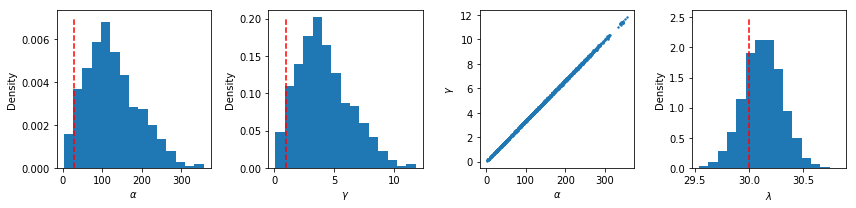

In [7]:
def plot_posterior_oned(x,label):
    plt.hist(x,bins=15,density=True)
    plt.xlabel(label)
    plt.ylabel('Density')

fig = plt.figure(figsize=(12,3))
plt.subplot(1,4,1)
plot_posterior_oned(alpha_inferred,r'$\alpha$')
plt.plot([30,30],[0,0.007],'r--')
plt.subplot(1,4,2)
plot_posterior_oned(gamma_inferred,r'$\gamma$')
plt.plot([1,1],[0,0.2],'r--')
plt.subplot(1,4,3)
plt.scatter(alpha_inferred,gamma_inferred,s=2)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\gamma$')
plt.subplot(1,4,4)
plot_posterior_oned(lambda_inferred,r'$\lambda$')
plt.plot([30,30],[0,2.5],'r--')

plt.tight_layout()

We can see from the histograms that $\alpha$ and $\gamma$ are all over the place, and plotting both parameters together (the plot of $\alpha$ vs $\gamma$) shows that they slide along a valley together. We know from the simulations that it's really the *ratio* of $\alpha/\gamma$ that's important (and sets the $\lambda$ parameter), so we have a horrible correlation in the parameter estimates between $\alpha$ and $\gamma$. However, the posterior parameter estimates for $\lambda$ includes the true value (30, shown in red). In other terms, we can't disentangle and individually infer the production and degradation rate parameters, but we can reliably infer their ratio. For this particular case, we can say that we're able to infer the transcription rate *scaled* by the mRNA degradation rate. This is a rather trivial example of problems with parameter identifiability, but we'll see another case that's more subtle in Model 2.

## Model 2 - the beta-Poisson mixture model

One of the major problems with the basic Poisson model is that it's too simple: it only has one parameter, and the variance is always equal to the mean. In real single-cell gene expression data this is rarely observed, and the Poisson model is too restrictive.

Live-cell imaging has shown that transcription is highly bursty [13](https://science.sciencemag.org/content/332/6028/472.abstract), and a common model known as the "telegraph model" is often used to describe this burstiness. The telegraph model assumes that genes switches discontinuously between an active and inactive state, where mRNA molecules are only produced in the active state. This can be represented with the following set of reactions:

\begin{align}
g_{\text{off}} &\overset{k_{\text{on}}}\longrightarrow g_{\text{on}} \: & \text{Promoter activation}\\
g_{\text{on}} &\overset{k_{\text{off}}}\longrightarrow g_{\text{off}} \: & \text{Promoter deactivation} \\
g_{\text{on}} &\overset{\alpha}\longrightarrow g_{\text{on}} + M \: & \text{Transcription} \\
M &\overset{\gamma}\longrightarrow \emptyset \: & \text{mRNA degradation} \\
\end{align}

The differences between the basic Poisson model (equivalent to constitutive expression) and the telegraph model is discussed in [14](https://science.sciencemag.org/content/336/6078/183), which includes some great visualisations.

Let's see an example of the telegraph model in action. Below we see an example time series, where $k_{\text{on}}$ and $k_{\text{off}}$ are both equal to 0.5, the transcription rate $\alpha=50$ and the degradation rate $\gamma=1$.

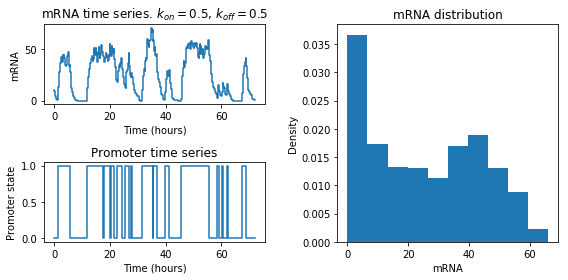

In [62]:
y_slow_mRNA = pd.read_csv('Model2_slow_mRNA.csv',header=None).values  
y_slow_promoter = pd.read_csv('Model2_slow_promoter.csv',header=None).values  

fig = plt.figure(figsize=(8,4))
plt.subplot(2,2,1)
plot_time_series(t,y_slow_mRNA[:,0])  
plt.title(r'mRNA time series. $k_{on} = 0.5$, $k_{off} = 0.5$')

plt.subplot(2,2,3)
plot_time_series(t,y_slow_promoter[:,0]) 
plt.ylabel('Promoter state')
plt.title(r'Promoter time series')

plt.subplot(1,2,2)
plot_hist(y_slow_mRNA[-1,:],bins=10)
plt.title(r'mRNA distribution')

plt.tight_layout()

In this parameter regime, the switching between the on and off promoter state is relatively slow. We can see that mRNA is increasing while the promoter is in an active state (left column). Averaging across 1000 cells (right column) we see a bimodal mRNA distribution. But what is the exact probability distribution? To solve this model using the formulation from above, the production rate $M_t$ follows a telegraph process that randomly switches between the on and off state. It's then possible to solve the random differential equation for $X_t$, which turns out to be a beta distribution (see [15](https://link.springer.com/article/10.1007/s00285-009-0298-z) or [Dattani](https://doi.org/10.1098/rsif.2016.0833) for details). The full model for the mRNA distribution then becomes a beta-Poisson mixture, and (to my knowledge) the first paper to use this formulation for single-cell RNA-seq data was Kim and Marioni, 2013 [16](https://genomebiology.biomedcentral.com/articles/10.1186/gb-2013-14-1-r7).

We can code this model in STAN using latent variables (extra, unseen parameters). Instead of having a constant rate parameter for the Poisson, *each* cell *i* will have have its own parameter $p_i$, where each $p_i$ is drawn from a beta distribution (parameterised by $k_{\text{on}}$ and $k_{\text{off}}$). Mathematically, the model is given by:

\begin{align}
p_i \sim \text{Beta}(k_{\text{on}},k_{\text{off}}) \\
y_i \sim \text{Poisson}(\alpha p_i)
\end{align}

Note that the degradation rate $\gamma$ is missing from this formulation, which is again impossible to infer using only the mRNA distribution and hence timescales are normalised in terms of the mRNA degradation rate.  Now let's code the model in STAN and see if it's possible to reliably infer the parameters!

In [63]:
model2 = """
data {
    int<lower=1> N;
    int y[N];
}
parameters {
    real<lower=0> k_on;
    real<lower=0> k_off;
    real<lower=0> alpha;
    vector<lower=0, upper=1>[N] p;
}
model {
    y ~ poisson(alpha*p);
    p ~ beta(k_on,k_off);
    k_on ~ normal(0,100);
    k_off ~ normal(0,100);
    alpha ~ normal(0,100);
}
    
"""

dat = {
    'N' : len(y_slow_mRNA[-1,:]),
    'y' : y_slow_mRNA[-1,:]
}

sm = pystan.StanModel(model_code=model2)
fit = sm.sampling(data=dat, iter=2000, chains=4)
a = fit.extract(permuted=True)  

k_on_inferred = a['k_on']
k_off_inferred = a['k_off']
alpha_inferred = a['alpha']
p_inferred = a['p']

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e2f232d338e122c2857e8baec2526a9e NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


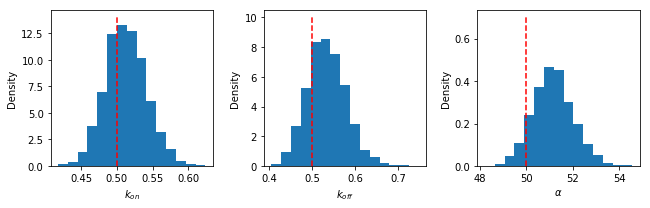

In [65]:
fig = plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
plot_posterior_oned(k_on_inferred,r'$k_{on}$')
plt.plot([0.5,0.5],[0,14],'r--')
plt.subplot(1,3,2)
plot_posterior_oned(k_off_inferred,r'$k_{off}$')
plt.plot([0.5,0.5],[0,10],'r--')
plt.subplot(1,3,3)
plot_posterior_oned(alpha_inferred,r'$\alpha$')
plt.plot([50,50],[0,0.7],'r--')

plt.tight_layout()

As we can see in the posterior parameter histograms, the true value (shown in red) is contained within most of the posterior parameter distribution.

The beta-Poisson model might seem like an attractive model in that it provides more flexibility than the standard Poisson distribution while still being based on a biophysical model of transcription with interpretable parameters. 

However, we will now see an example that illustrates some potential pathologies of this model. Let's imagine that the switching between on and off state becomes fast relative to the mRNA degradation timescale ($k_{\text{on}}$ and $k_{\text{off}}$ are both equal to 30) and look at another time series:

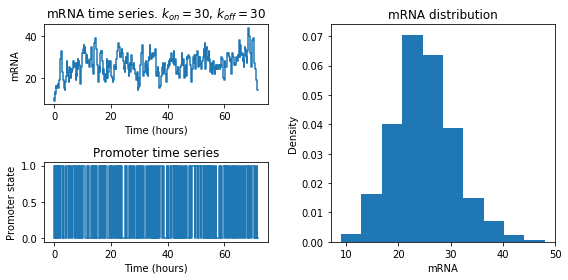

In [72]:
y_fast_mRNA = pd.read_csv('Model2_fast_mRNA.csv',header=None).values  
y_fast_promoter = pd.read_csv('Model2_fast_promoter.csv',header=None).values  

fig = plt.figure(figsize=(8,4))
plt.subplot(2,2,1)
plot_time_series(t,y_fast_mRNA[:,0])  
plt.title(r'mRNA time series. $k_{on} = 30$, $k_{off} = 30$')

plt.subplot(2,2,3)
plot_time_series(t,y_fast_promoter[:,0]) 
plt.ylabel('Promoter state')
plt.title(r'Promoter time series')

plt.subplot(1,2,2)
plot_hist(y_fast_mRNA[-1,:],bins=10)
plt.title(r'mRNA distribution')

plt.tight_layout()

Now let's use the same STAN model for inference:

In [73]:
dat = {
    'N' : len(y_fast_mRNA[-1,:]),
    'y' : y_fast_mRNA[-1,:]
}

fit = sm.sampling(data=dat, iter=2000, chains=4)
a = fit.extract(permuted=True)  

k_on_inferred = a['k_on']
k_off_inferred = a['k_off']
alpha_inferred = a['alpha']
p_inferred = a['p']

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


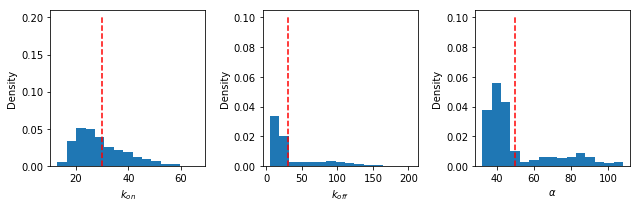

In [74]:
fig = plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
plot_posterior_oned(k_on_inferred,r'$k_{on}$')
plt.plot([30,30],[0,0.2],'r--')
plt.subplot(1,3,2)
plot_posterior_oned(k_off_inferred,r'$k_{off}$')
plt.plot([30,30],[0,0.1],'r--')
plt.subplot(1,3,3)
plot_posterior_oned(alpha_inferred,r'$\alpha$')
plt.plot([50,50],[0,0.1],'r--')

plt.tight_layout()

We can see STAN is not happy with the inference procedure (we see several warning messages related to STAN diagnostics) and the parameter posterior distributions are a mess. In fact, for this parameter regime there is a problem of parameter identifiability as the switching between on and off states is so fast that the mRNA distribution becomes similar to a standard Poisson. In other words, for some parameter combinations the inference procedure is not robust for Model 2.

## Model 3: the negative binomial (gamma-Poisson) distribution

The negative binomial distribution has become common for modelling mRNA distributions in both smFISH and RNA-seq datasets. But where does this negative binomial distribution come from, and how is it related to transcriptional dynamics? Interestingly, there are (at least) three different ways you can generate a negative binomial distribution. We'll first look at stochastic simulations before describing them below

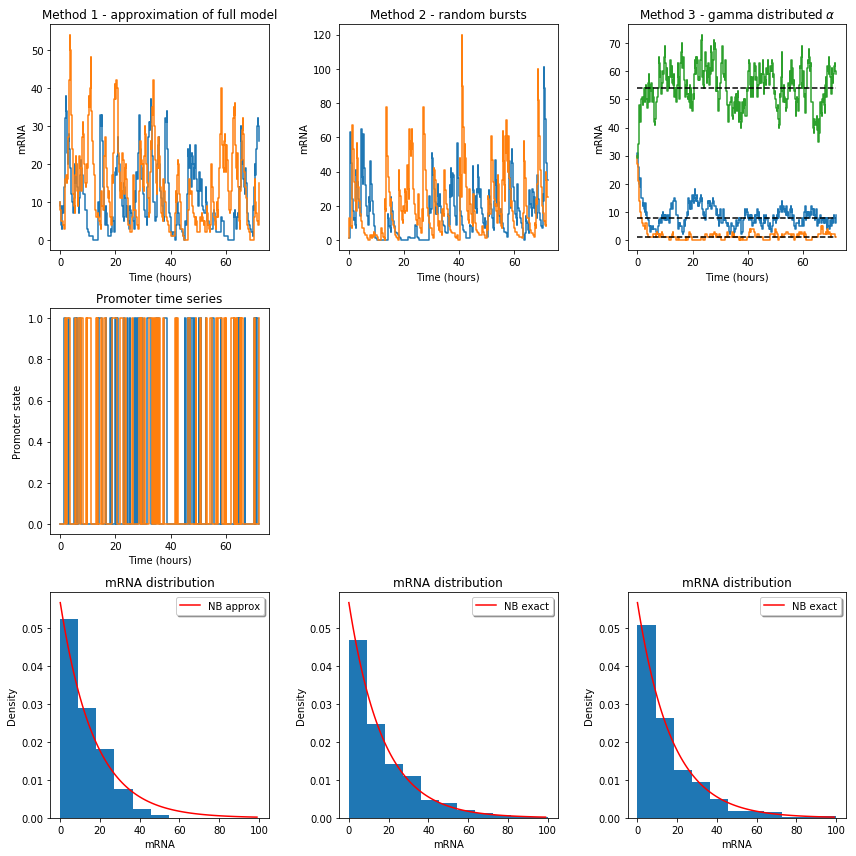

In [101]:
y_method1_mRNA = pd.read_csv('Model3_method1_mRNA.csv',header=None).values  
y_method1_promoter = pd.read_csv('Model3_method1_promoter.csv',header=None).values  
y_method2_mRNA = pd.read_csv('Model3_method2_mRNA.csv',header=None).values  
y_method3_mRNA = pd.read_csv('Model3_method3_mRNA.csv',header=None).values  
y_method3_alpha = pd.read_csv('Model3_method3_alpha.csv',header=None).values 

fig = plt.figure(figsize=(12,12))
plt.subplot(3,3,1)
plot_time_series(t,y_method1_mRNA[:,0])  
plot_time_series(t,y_method1_mRNA[:,1]) 
plt.title(r'Method 1 - approximation of full model')

plt.subplot(3,3,4)
plot_time_series(t,y_method1_promoter[:,0]) 
plot_time_series(t,y_method1_promoter[:,1]) 
plt.ylabel('Promoter state')
plt.title(r'Promoter time series')

plt.subplot(3,3,7)
plot_hist(y_method1_mRNA[-1,:],bins=np.linspace(0,100,12))
plt.title(r'mRNA distribution')

b = 50/3
r = 1
x_vec = range(100)
p_tot = np.zeros(len(x_vec))

for i in range(len(x_vec)):
        x = x_vec[i]
        m = b*r
        p = r/(m+r)
        y = nbinom.pmf(x, r, p)
        p_tot[i] = y

plt.plot(x_vec,p_tot,'r',label='NB approx')   
legend = plt.legend(loc='upper right', shadow=True)

plt.subplot(3,3,2)
plot_time_series(t,y_method2_mRNA[:,0])  
plot_time_series(t,y_method2_mRNA[:,1])  
plt.title(r'Method 2 - random bursts')

plt.subplot(3,3,8)
plot_hist(y_method2_mRNA[-1,:],bins=np.linspace(0,100,12))
plt.title(r'mRNA distribution')
plt.plot(x_vec,p_tot,'r',label='NB exact')   
legend = plt.legend(loc='upper right', shadow=True)

plt.subplot(3,3,3)
plot_time_series(t,y_method3_mRNA[:,0])  
plot_time_series(t,y_method3_mRNA[:,1]) 
plot_time_series(t,y_method3_mRNA[:,2]) 
plt.plot([t[0],t[-1]],[y_method3_alpha[0],y_method3_alpha[0]],'k--')  
plt.plot([t[0],t[-1]],[y_method3_alpha[1],y_method3_alpha[1]],'k--') 
plt.plot([t[0],t[-1]],[y_method3_alpha[2],y_method3_alpha[2]],'k--')  
plt.title(r'Method 3 - gamma distributed $\alpha$')

plt.subplot(3,3,9)
plot_hist(y_method3_mRNA[-1,:],bins=np.linspace(0,100,12))
plt.title(r'mRNA distribution')
plt.plot(x_vec,p_tot,'r',label='NB exact')   
legend = plt.legend(loc='upper right', shadow=True)

plt.tight_layout()

*Method 1: as an approximation of the full telegraph model when burst are short*. In the regime where burst are short (i.e. a large ratio $k_{\text{off}}/\gamma$), the full model can be approximated by the negative binomial distribution (see Raj et al. 2006 Supp Material [17](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.0040309) ). In contrast to the full telegraph model (which has 3 parameters, exluding the degradation rate that is impossible to infer), the negative binomial distribution has two parameters: a burst size and burst frequency. A negative binomial distribution is less flexible than the beta-Poisson distribution and can never give rise to a bimodal distribution. However, the short burst size is probably a reasonable assumption for many mammalian genes [13](https://science.sciencemag.org/content/332/6028/472.abstract) and parameter inference is generally more robust.

*Method 2: instantaneous bursts of mRNA production*. In contrast to the approximation made in Method 1, it's possible to use a slightly different model of transcription that will give rise to a negative binomial as the exact distribution. In Friedman et al. 2006 [18](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.97.168302), the authors consider a model of protein dynamics where protein production occurs in random bursts with an exponentially distributed number of molecules, and they show that this model leads to a gamma distribution in steady state. In fact, the model they used was equivalent to solving the random differential equation for $X_t$ where the production term $M_t$ is described by instantaneous, exponentially distributed injections. In the time series for Method 2 you can see that mRNA increases in discontinuous bursts. When the mixture distribution of the Poisson distribution is a gamma distribution, the integral can be performed analytically and leads to a negative binomial distribution (see wiki page for details [19](https://en.wikipedia.org/wiki/Negative_binomial_distribution)).

*Method 3: a simple model of extrinsic noise*. A negative binomial distribution can also be created with an entirely different generative model. It is unrealistic to assume that all cells have exactly the same kinetic parameters, and parameter variability could arise from many different mechanisms (e.g. differences in concentration of transcriptional enzymes, cell volume etc.). Let's imagine that the transcription rate varies according to a gamma distribution. In the time series for Method 3 we see that cells fluctuate around their own mean, which is dictated by their individual transcription parameter. In each cell there is a Poisson distribution with a rate parameter equal to the hidden (latent) transcription rate. Given that the transcription rate is gamma distributed, we once again recover a negative binomial distribution across the whole population.

Methods 2 and 3 once again illustrate a very important principle: different dynamical models can produce the same stationary distributions. 

We can code any of the models in STAN using a negative binomial distribution.

Option 1: directly use a negative binomial distribution.

In [ ]:
model3 = """
data {
    int<lower=1> N;
    int y[N];
}
parameters {
    real<lower=0> b;
    real<lower=0> f;
}
model {
    y ~ neg_binomial_2( b*f , f);
    b ~ normal(0,100);
    f ~ normal(0,100);
}
    
"""

For Method 3, we could alternatively give each cell its own (latent) transcription parameter that is drawn from a gamma distribution. This method is less efficient because each cell has an associated latent variable.

Option 2: use a latent variable representation with a gamma mixture of Poisson distributions.

In [ ]:
model3 = """
data {
    int<lower=1> N;
    int y[N];
}
parameters {
    real<lower=0> b;
    real<lower=0> f;
    real<lower=0> alpha[N];
}
model {
    y ~ poisson(alpha);
    alpha ~ gamma(f,b):
    b ~ normal(0,100);
    f ~ normal(0,100);
}
    
"""

## Model 4: the multivariate log-normal Poisson mixture distribution

Instead of using a gamma distribution, we could be more open-minded about what type of distribution we use for the mixing distribution. We could, for example, use a log-normal distribution instead of a gamma distribution (similarly to as performed here: [6](https://doi.org/10.1038/s41587-021-00875-x)). There are many different ways that one could generate a log-normal distribution. Mechanistically, we could assume that the transcription process $X_t$ follows a modified Ornstein-Uhlenbeck process in log space. Alternatively, the central limit theorem in the log domain tells us that we expect a log-normal distribution when we multiply many independent variables. 

We saw that the negative binomial distribution could be generated by either purely intrinsic (transcriptional bursting) or extrinsic (differences in transcription rate) mechanisms. We could also decide to be agnostic and say: we'll use the log-normal to model everything (both intrinsic and extrinsic) that we can't measure and that will create super-poissonian noise.

With a multivariate log-normal distribution it's also possible to introduce correlation between genes and hence encode networks of statistical relationships. This is also an opportunity to show another nice feature of STAN. A correlation matrix has a certain structure (symmetric and positive semi-definite), so we could have problems if we encode each entry in the correlation matrix as a free parameter. Fortunately, in STAN there is a special data type for correlation matrices that will ensure that this doesn't cause a problem. Here is an example of how you could code this in STAN for a matrix of gene expression counts $Y$ with $N$ cells and $K$ number of genes. Note that we use a "non-centred" parameterisation for the log-normal latent variables (see the STAN reference manual for discussion).

In [ ]:
model4 = """
data {
    int<lower=1> N;
    int<lower=1> K;
    int<lower=0> Y[N,K];
}
parameters {
    row_vector[K] mu_vec;
    matrix[N, K] eta;
    cholesky_factor_corr[K] L;
    vector[K] sigma_vec;
}
transformed parameters{
    matrix[N, K] Z;
    matrix[K, K] C;
    corr = L*L';
    for ( n in 1:N ) {
        Z[n,:] = exp(mu_vec + (diag_pre_multiply(sigma_vec,L)*(eta[n,:])')');
    }
}
model {
    to_vector(eta) ~ normal(0, 1);
    for ( k in 1:K ) {
        Y[:,k] ~ poisson(Z[:,k]);
    }
    mu_vec ~ normal(0,100);
    sigma_vec ~ normal(0,100);
    L ~ lkj_corr_cholesky(2.0);
}
    
"""

## Model 5: incorportating extrinsic noise explicitly

There is somewhat of a debate within the single-cell gene expression community about how much single cell noise is due to intrinsic vs extrinsic factors. 

We saw a very interesting example for the negative binomial distribution, where intrinsic noise (caused by transcriptional bursting) and extrinsic noise (caused by cell-to-cell parameter differences) generated exactly the same mRNA distribution.

So how will we ever know the real contribution of extrinsic noise? One approach is to measure as many possible cellular variables as possible and see whether knowledge of these variables helps predict gene expression in a given cell. In Battich et al. 2015 [20](https://www.cell.com/fulltext/S0092-8674(15)01498-1), for an example, they measured 183 features including cell area, shape, cell crowding, neighbourhood activity etc. 

We can incorporate any additional cellular measurements into our STAN model. The measured cellular features can be supplied as an additional data input in the STAN data block. You could either use the original measured cellular features or perhaps a lower-dimensional representation using either a linear or nonlinear dimensionality reduction technique. You could even try and do this in STAN if you were feeling adventurous! 

We still need to define the distribution of mRNA counts *given* all of the external cellular variables (i.e. we still need to define a model of the remaining intrinsic noise once we have the cellular information). You can experiment with any of the Models 1-4. In our recent paper we used a negative binomial distribution, but if you decide to do this then you need to define whether the additional measurements affect either burst size or burst frequency.

There is previous work ([21](https://www.cell.com/molecular-cell/pdfExtended/S1097-2765(15)00170-7)) showing that burst size is a function of cell volume, so let's code this as a STAN model as a simple example where the burst size $b$ is now rescaled by the volume $v$ to become $bv$, and where we enter the volume $v$ as an extra data input.

In [ ]:
model5 = """
data {
    int<lower=1> N;
    int y[N];
    int v[N]; // cell volume
}
parameters {
    real<lower=0> b;
    real<lower=0> f;
}
model {
    y ~ neg_binomial_2( b*v*f , f);
    b ~ normal(0,100);
    f ~ normal(0,100);
}
    
"""

## Technical noise

We've discussed models of biological cell-to-cell variability originating from either intrinsic or extrinsic sources (as modelled with models 1-5), but the measurement process can also contribute technical noise. The measurement process will inevitably introduce extra variability into the data and distort the "true" molecule count. 

For smFISH, for example, it's possible to either miss an existing mRNA molecule (i.e. false negative) or call an mRNA molecule when it doesn't exist (i.e. a false positive). Modelling technical noise is an area where detailed consideration of the measurement process is essential. We can add an extra layer of measurement noise in any way we like in STAN. For the smFISH example, perhaps it's reasonable to assume that for each true mRNA molecule there is a fixed probability $p$ of missing a true mRNA molecule, and we could then add an extra binomial noise level to our model using this probability $p$. But what value of $p$ do we use? This is where careful positive and negative control experiments can supply you with numbers to use as part of the STAN model.

For single-cell RNA-seq the question of technical noise is even more controversial. Grün et al. 2014 [22](https://www.nature.com/articles/nmeth.2930) proposed several models of RNA-seq technical noise to account for sampling noise and global cell-to-cell variation in sequencing efficiency, including a model where the measured data is sampled from the underlying mRNA count according to a negative binomial distribution. Many RNA-seq papers also include "dropout" (or zero inflation) as part of their technical noise model, although there is some debate about whether this is really justified [23](https://www.nature.com/articles/s41587-019-0379-5). There are many different options for implementing these technical noise models, and it's particularly important to consider the consequences of the technical noise on the ability to successfully infer the underlying biological parameters.

## Model selection and validation

Let's first acknowledge that model (or theory) selection and validation is a crucial feature of basically every scientific discipline, and unfortunately there is no magic formula that will tell us whether a theory or model is a good representation of objective reality. 

One important point to note regarding our STAN models: our models are defined in terms of discrete probability distributions that explicitly describe count data, and we evaluate the likelihood of observing a given data point using this discrete probability distribution. Notions of model fit based e.g. on mean squared error make little sense in this context (at least to me). 

After model fitting, a reasonable starting point is to present a visual, side-by-side comparison of the data and model predictions. There are often obvious qualitative similarities or differences that are revealed by this basic comparison, and it's a simple form of model checking that everyone can understand. 

Beyond this basic check, we'd like to put numbers on our preference for a model. There are so many options for model selection, including AIC, BIC, WAIC, Bayes factors, cross-validation (CV) etc., that choosing a method can feel quite overwhelming.

You can find a detailed discussion of the various model selection options in most Bayesian analysis textbooks. Despite the potential pitfalls and caveats (including problems when comparing many different models), cross-validation seems overall like a reasonable approach. In our paper we tried two different approaches:

* I found this paper particularly helpful for clarifying different concepts [21](https://link.springer.com/article/10.1007/s11222-016-9696-4) and subsequently used Pareto-smoothed importance sampling leave-one-out cross-validation (PSIS-LOO) for model selection in our paper. PSIS-LOO is available as a package that accepts the output from STAN inference. 

* If there's structure in the data that naturally provides an interesting way of splitting data, you can also be more creative about cross-validation strategies. For example, in our paper we used "leave-replicate-out" CV where each test subsample was a separate slide that had been physically isolated from other cells during the experiment.

An even more interesting method of model validation is to test predictions on previously unseen perturbations. A really nice illustration of this approach is here: [22](https://www.sciencedirect.com/science/article/pii/S2589004220307574). Just like the construction of the STAN models, it's possible to combine or mix-and-match between these different techniques.

## Strengths and limitations of the approach

When defining our models we assumed that the biological system is in a stationary state, although it's still possible to use the framework without this assumption. We need to solve the random differential equation to calculate the probability distribution $p_{X_t}(x,t)$ of the process $X_t$, and for our simple models of bursty gene expression this was possible.

The underlying dynamics of real biological systems are undoubtably far more complicated. For example, transcription might be regulated by nonlinear positive and negative feedback interactions between multiple transcription factors. We've also neglected spatial dimensions and diffusion in our model.

If you'd like to add e.g. feedback of proteins onto transcription rates then in most cases these models have no analytical solution. There are several alternative techniques that allow more general models, such as the Finite State Projection [23](https://aip.scitation.org/doi/abs/10.1063/1.4960505) or likelihood-free computational inference techniques [24](https://www.sciencedirect.com/science/article/abs/pii/S0022519320301107?via%3Dihub). It's currently quite difficult to scale these techniques to thousands of genes, but they are certainly interesting options that for exploring more detailed, mechanistic models. The downside is that it's often not possible to use the efficient implementation of parameter exploration (HMC) that STAN uses for these approaches.

On the other end of the spectrum, neural networks are becoming increasingly popular for analysing single-cell RNA-seq data. Tensorflow Probability would be particularly interesting if you'd like to combine some of the models presented in this tutorial with neural networks. In Tensorflow Probability, for example, you can use a neural network to set the parameters of a negative binomial likelihood function.

These choices form part of a wider debate on whether more detailed, mechanistic models or more flexible but mechanistically agnostic machine learning approaches are going to bring the most insight into single-cell datasets (or indeed hybrid models). Who knows what we'll be doing 10 years from now? All I can say is that if you're interested in Bayesian analysis then STAN is definitely worth checking out.